## Project: Development of a reduced pediatric injury prediction model
Created by: Thomas Hartka, MD, MS  
Date created: 12/20/20  
  
This notebook evaluates the reduced variable-set model found by Bayesian model averaging and variable number analysis.  This uses ten-fold cross-validation, but uses different fold assignments than the original analysis.

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
import scipy.stats as st
from itertools import combinations
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

## Set outcome

In [2]:
# outcome of interest
#  ISS -> ISS>=16
#  TIL -> any injury on target injury list
outcome = "ISS"

filter_missing = True

## Read in data

In [3]:
peds = pd.read_csv("../Data/Peds-2010_2018-unfiltered.csv")

In [4]:
# filter out CISS cases if using TIL because TIL is only valid for AIS98
if outcome == "TIL":
    peds = peds[peds.dataset=='NASS']

## Set variables

In [21]:
predictors = ['sex','age_5_9', 'age_10_14','age_15_18',
              'prop_restraint','any_restraint','front_row', 
              'dvtotal','pdof_rear','pdof_nearside','pdof_farside', 
              'rolled','multicoll','ejection',
              'splimit','abdeply','entrapment']

predictors_wo_dv = ['sex','age_5_9', 'age_10_14','age_15_18',
              'prop_restraint','any_restraint','front_row', 
              'pdof_rear','pdof_nearside','pdof_farside', 
              'rolled','multicoll','ejection',
              'splimit','abdeply','entrapment']

if outcome == "ISS":
    predictors_reduced = ['dvtotal','entrapment','any_restraint','ejection','pdof_nearside']
    response_train = 'iss16'
    
elif outcome == "TIL":
    predictors_reduced = ['dvtotal','entrapment','any_restraint','ejection','pdof_nearside', 'multicoll']
    response_train = 'target_inj'
    
else:
    raise Exception("Outcome not valid") 
    
response_test = 'iss16'

## Filter cases with missing data

In [6]:
# filter cases with missing values
if filter_missing:
    # columns we care about
    missing_cols = ['dvtotal','pdof_front','rolled','prop_restraint','any_restraint']
    
    # remove rows with missing values
    peds = peds.dropna(subset=predictors).reset_index(drop=True)

## Create new fold assignments

In [7]:
# drop existing fold columns
peds = peds.drop(columns=['fold10x','fold5x'])

In [8]:
num_folds = 10

# initial fold column
folds = pd.Series(-1).repeat(len(peds)).reset_index(drop=True)

# set up k-fold generator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=2716057)

# get splits for data
kf.get_n_splits(peds)
        
# interate through folds and assign fold number to cases
for i,row_list in enumerate(kf.split(peds)):
      folds.loc[row_list[1]] = i
    
peds['fold'] = folds

## Cross validation logistic regression function

In [9]:
def log_reg_cv(data, predictors, response_train, response_test, threshold=0.5):
    '''
    This function performs lass regression using 10-fold cross validation.  
    It returns a dataframe with the coefficients for each fold and auc.
    
    Parameters:
        data - data to analyze
        predictors - list of columns for predictors
    Returns:
        cofficient/AUC - DataFrame(contains AUC, fold, cofficients for model)
    '''
    
    # get folds
    folds = np.sort(data['fold'].unique())
    
    # create dataframe for results
    results = pd.DataFrame(columns=['num_vars','fold']+predictors+['AUC']+ \
                           ['tp','fp','tn','fn','tpwgt','fpwgt','tnwgt','fnwgt'] + \
                           ['sens','spec','senswgt','specwgt'] + \
                           ['total','totalwgt'])
    
    # set up LR model
    lr_mod = LogisticRegression(random_state=1819, penalty='none',solver='saga',max_iter=10000)
    
    # loop through folds
    for fold in folds:
        # separate fold train/test data
        train = data[data['fold']!=fold].copy()
        test = data[data['fold']==fold].copy()

        # fit regression model
        lr_fit = lr_mod.fit(train[predictors], train[response_train])

        # predict on fold test data
        pred = lr_fit.predict_proba(test[predictors])
        test['pred'] = pred[:,1]
        
        # calc AUC
        fpr, tpr, thresholds = metrics.roc_curve(test[response_test], pred[:,1], pos_label=1)
        AUC = metrics.auc(fpr, tpr)

        # gather results
        fold_results = [len(predictors), fold]
        for i,var in enumerate(predictors):
            fold_results.append(lr_fit.coef_[0,i])
        fold_results += [AUC]
        
        # get performance characteristics
        tp = test[(test.pred>=threshold) & (test[response_test]==1)].casewgt.count()
        fp = test[(test.pred>=threshold) & (test[response_test]==0)].casewgt.count()
        tn = test[(test.pred<=threshold) & (test[response_test]==0)].casewgt.count()
        fn = test[(test.pred<=threshold) & (test[response_test]==1)].casewgt.count()
        
        # get weighted performance characteristics
        tpwgt = test[(test.pred>=threshold) & (test[response_test]==1)].casewgt.sum()
        fpwgt = test[(test.pred>=threshold) & (test[response_test]==0)].casewgt.sum()
        tnwgt = test[(test.pred<=threshold) & (test[response_test]==0)].casewgt.sum()
        fnwgt = test[(test.pred<=threshold) & (test[response_test]==1)].casewgt.sum()
        
        # calc sensitivity and specificity 
        sens = tp / (tp+fn)
        spec = tn / (tn+fp)
        senswgt = tpwgt / (tpwgt+fnwgt)
        specwgt = tnwgt / (tnwgt+fpwgt)
        
        # calc totals
        total = tp+fp+tn+fn
        totalwgt = tpwgt+fpwgt+tnwgt+fnwgt
        
        fold_results += [tp]+[fp]+[tn]+[fn]+\
                        [tpwgt]+[fpwgt]+[tnwgt]+[fnwgt]+\
                        [sens]+[spec]+[senswgt]+[specwgt]+\
                        [total]+[totalwgt]

        # store AUC
        fold_series = pd.Series(fold_results, index = results.columns)
        results = results.append(fold_series, ignore_index=True)
    
    
    return results

## Compare AUCs of baseline and reduced models

In [10]:
def results_CI(results,sig_dig=2):
    mean = results.AUC.mean()
    sd = results.AUC.std()
    
    print("SD:",sd)

    # calculate lower and upper 95% CI
    ll = round(mean - 1.96*sd, sig_dig)
    ul = round(mean + 1.96*sd, sig_dig)
    
    mean = round(mean, sig_dig)
    
    print(mean,"[",ll,"-",ul,"]")

In [11]:
%%time
results = log_reg_cv(peds,predictors,response_train, response_test)
results_reduced = log_reg_cv(peds,predictors_reduced,response_train, response_test)

CPU times: user 2min 46s, sys: 7.52 s, total: 2min 54s
Wall time: 1min 55s


In [12]:
results_CI(results,3)

SD: 0.022768080464503303
0.907 [ 0.862 - 0.952 ]


In [13]:
results_CI(results_reduced,3)

SD: 0.03278549611066127
0.899 [ 0.835 - 0.963 ]


## Examine model without delta-V

In [22]:
%%time
results_wo_dv = log_reg_cv(peds,predictors_wo_dv,response_train, response_test)

CPU times: user 1min 7s, sys: 3.56 s, total: 1min 10s
Wall time: 41.1 s


In [23]:
results_CI(results_wo_dv,3)

SD: 0.02670962735747859
0.819 [ 0.766 - 0.871 ]


## Examine probability thresholds

In [15]:
%%time
thresholds = pd.DataFrame(columns=['threshold','sens','spec','senswgt','specwgt'])
                                   
for i in np.linspace(0.0,0.05,11):
    thres_res = log_reg_cv(peds,predictors_reduced,response_train, response_test,threshold=i)
    res = [i]+[thres_res.sens.mean()]+[thres_res.spec.mean()]+[thres_res.senswgt.mean()]+[thres_res.specwgt.mean()]
    
    thres_means = pd.Series(res, index = thresholds.columns)
    thresholds = thresholds.append(thres_means, ignore_index=True)
    
    print(i)

0.0
0.005
0.01
0.015
0.02
0.025
0.03
0.035
0.04
0.045
0.05
CPU times: user 12min 34s, sys: 44 s, total: 13min 18s
Wall time: 8min 1s


In [16]:
thresholds

,threshold,sens,spec,senswgt,specwgt
0,0.000,1.000000,0.000000,1.000000,0.000000
1,0.005,0.998529,0.106946,0.999565,0.160485
2,0.010,0.970795,0.407582,0.894967,0.534133
3,0.015,0.945918,0.568421,0.873710,0.700356
4,0.020,0.923123,0.666966,0.809444,0.807150
5,0.025,0.891175,0.736079,0.791103,0.863280
6,0.030,0.864111,0.780131,0.757741,0.892957
7,0.035,0.839797,0.809330,0.745944,0.909373
8,0.040,0.806518,0.832165,0.726657,0.926445
9,0.045,0.786447,0.851819,0.670408,0.938758


## Calculate under and over triage rates

In [17]:
triage = thresholds[['threshold','senswgt','specwgt']].copy()

# calculate undertriage and overtriage
triage['Undertriage rate'] = 1-triage.senswgt 
triage['Overtriage rate'] = 1-triage.specwgt 

triage[['threshold','Undertriage rate','Overtriage rate']].rename(columns={'threshold':'Probability Threshold'})

,Probability Threshold,Undertriage rate,Overtriage rate
0,0.000,0.000000,1.000000
1,0.005,0.000435,0.839515
2,0.010,0.105033,0.465867
3,0.015,0.126290,0.299644
4,0.020,0.190556,0.192850
5,0.025,0.208897,0.136720
6,0.030,0.242259,0.107043
7,0.035,0.254056,0.090627
8,0.040,0.273343,0.073555
9,0.045,0.329592,0.061242


## Plot over and undertriage rates

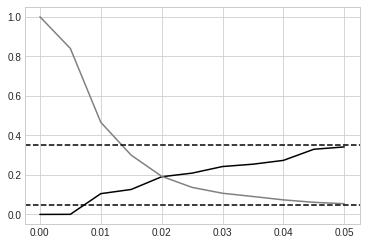

In [18]:
plt.plot(triage.threshold, triage['Undertriage rate'], '-', color='black')
plt.plot(triage.threshold, triage['Overtriage rate'], '-', color='gray')
plt.axhline(y=0.05, color='black', linestyle='--')
plt.axhline(y=0.35, color='black', linestyle='--')